# Bilinear Patches
Games programming typically includes many objects of various types in game environments.

In the previous workbook, we examined the construction of parameterised mathematical surfaces. Now we will consider surfaces comprising of discrete datapoints, and how to construct surface patches between four such points. In doing so, we will examine how the tangent and normal calculations found last time extend to also work for surface patches.

In [4]:
## Libraries
%matplotlib inline
import numpy as np
import sympy as sym
import math as math
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d
from sympy.utilities.lambdify import lambdify, implemented_function

In [5]:
#we'll need to draw arrows for the 3D bit:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

## Background

Discrete datapoints provide a slightly more flexible way to sample a surface; however, these datapoints do not provide any information of what the surface may look like away from these datapoints.

A bilinear surface patch can be constructed between four datapoints, taking a weighted average of each of the four corners (depending on the linear distance from each corner). In the below image taken from Wikimedia, the contribution of each corner can be visually represented by the area on the opposite side of the patch: 

![Picture](https://upload.wikimedia.org/wikipedia/commons/9/91/Bilinear_interpolation_visualisation.svg?raw=1)

Mathematically, we assign a parameter to a direction aligned with one of the edges of the patch. These parameters are typically labelled as $u$ and $v$, and can vary between $0$ and $1$; at exactly $0$ or exactly $1$, this indicates a position on the edge of the patch.

Any/every location on the patch can be found using a specific set of values of $u$ and $v$, with a position vector determined according to:

$$
{\mathbf{\vec{q}}}(u,v) = (1-v)(1-u){\mathbf{\vec{a}}}+(1-v)u{\mathbf{\vec{b}}}+v(1-u){\mathbf{\vec{c}}}+vu{\mathbf{\vec{d}}},
$$
for a patch with corners ${\mathbf{\vec{a}}}={{\vec{0A}}}$, ${\mathbf{\vec{b}}}={{\vec{0B}}}$, ${\mathbf{\vec{c}}}={{\vec{0C}}}$ and ${{\vec{d}}}={\mathbf{\vec{0D}}}$, with $AB$ and $CD$ being opposite edges of the patch. 


### Example: Tutorial Q1
**Contruct the vector equation for the bilinear patch based on the line segments joining $A(0,0,0)$ with $B(1,0,0)$, and $C(0,1,1)$ with $D(1,1,0)$. Also determine the equation of the curve joining $A$ to $D$ on the surface.**

My aim here is to showcase how easily Python can be used to calculate and visualise the patch surface, and convert back from parameter space to Cartesian (real) space.

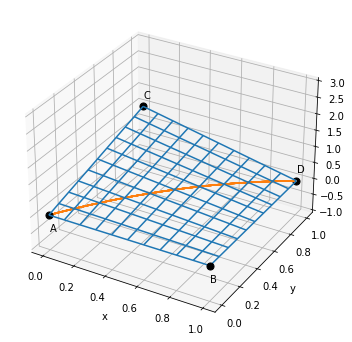

In [83]:
A = [0,0,0]
B = [1,0,0]
C = [0,1,1]
D = [1,1,0]

u, v  = sym.Symbol('u'), sym.Symbol('v') #parameter
q  = [ (1-v)*(1-u)*A[0]+(1-v)*u*B[0]+v*(1-u)*C[0]+v*u*D[0],
      (1-v)*(1-u)*A[1]+(1-v)*u*B[1]+v*(1-u)*C[1]+v*u*D[1],
      (1-v)*(1-u)*A[2]+(1-v)*u*B[2]+v*(1-u)*C[2]+v*u*D[2]]

xf = lambdify([u,v],q[0])
yf = lambdify([u,v],q[1])
zf = lambdify([u,v],q[2])

uvals = np.linspace(0,1, 21)  #range of parameter u
vvals = np.linspace(0,1, 21) #range of parameter v
myu, myv = np.meshgrid(uvals,vvals) # make a grid of values

# calculate x,y,z arrays of positions based on u and v
xvals, yvals, zvals = xf(myu,myv), yf(myu,myv), zf(myu,myv)
# calculate x,y,z arrays of line when v=u
xvals1, yvals1, zvals1 = xf(myu,myu), yf(myu,myu), zf(myu,myu)
# calculate x,y,z arrays of line when v=1-u
xvals2, yvals2, zvals2 = xf(myu,1-myu), yf(myu,1-myu), zf(myu,1-myu)

xlim = -1,3
ylim = -1,3
zlim = -1,3
#plotting
vfig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.set_zlim(*zlim)
surf = ax.plot_wireframe(xvals, yvals, zvals, rstride=2, cstride=2, label='patch')
surf = ax.plot_wireframe(xvals1, yvals1, zvals1, rstride=2, cstride=2, label='line AD', color='C1')
#surf = ax.plot_wireframe(xvals2, yvals2, zvals2, rstride=2, cstride=2, label='line BC', color='C2')
ax.scatter(A[0], A[1], A[2], color='k', s=50, label='A')
ax.text(A[0], A[1], A[2]-0.5, "A", size=10)
ax.scatter(B[0], B[1], B[2], color='k', s=50, label='B')
ax.text(B[0], B[1], B[2]-0.5, "B", size=10)
ax.scatter(C[0], C[1], C[2], color='k', s=50, label='C')
ax.text(C[0], C[1], C[2]+0.25, "C", size=10)
ax.scatter(D[0], D[1], D[2], color='k', s=50, label='D')
ax.text(D[0], D[1], D[2]+0.25, "D", size=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

This image shows the patch gently curving to join all four points, and the curve in real space which is a straight line in parameter space, linking the points A and D.

We've cheated a bit, as we haven't actually stated the patch equation nor the equation of the line, so we'll do that now:


In [52]:
print("patch equation:")
print(q)
print()
print("and the equation of the line linking AD:")
lineAD = [sym.simplify(q[0].subs({u:v})),sym.simplify(q[1].subs({u:v})),sym.simplify(q[2].subs({u:v}))]
print(lineAD)

patch equation:
[u*v + u*(1 - v), u*v + v*(1 - u), v*(1 - u)]

and the equation of the line linking AD:
[v, v, v*(1 - v)]


## Normal calculation?

We've seen that we can construct and view the surface patch. What if we need a normal to be calculated at some point on the patch? (After all rays may interact with this surface).

To do this, we'll use one of the more challenging tutorial questions:
**Contruct a bilinear patch for a surface whose corner points are at $A(0,0,0)$, $B(0,0,-1)$, $C(-1,1,1)$ and $D(1,1,2)$ using $AD$ and $BC$ as opposite line segments. Write doen the vector equation of the surface and determine a unit normal at the point where $u=v=1/2$.**


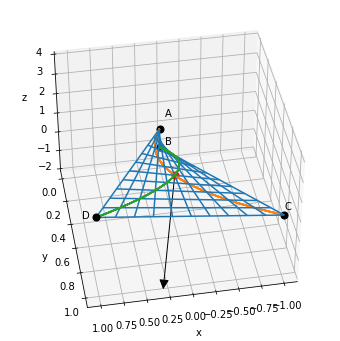

In [80]:
A = [0,0,0]
B = [0,0,-1]
C = [-1,1,1]
D = [1,1,2]

u, v  = sym.Symbol('u'), sym.Symbol('v') #parameter
q  = [ (1-v)*(1-u)*A[0]+(1-v)*u*D[0]+v*(1-u)*B[0]+v*u*C[0],
      (1-v)*(1-u)*A[1]+(1-v)*u*D[1]+v*(1-u)*B[1]+v*u*C[1],
      (1-v)*(1-u)*A[2]+(1-v)*u*D[2]+v*(1-u)*B[2]+v*u*C[2]]

xf = lambdify([u,v],q[0])
yf = lambdify([u,v],q[1])
zf = lambdify([u,v],q[2])

uvals = np.linspace(0,1, 21)  #range of parameter u
vvals = np.linspace(0,1, 21) #range of parameter v
myu, myv = np.meshgrid(uvals,vvals) # make a grid of values

# calculate x,y,z arrays of positions based on u and v
xvals, yvals, zvals = xf(myu,myv), yf(myu,myv), zf(myu,myv)
# calculate x,y,z arrays of line when v=u
xvals1, yvals1, zvals1 = xf(myu,myu), yf(myu,myu), zf(myu,myu)
# calculate x,y,z arrays of line when v=1-u
xvals2, yvals2, zvals2 = xf(myu,1-myu), yf(myu,1-myu), zf(myu,1-myu)

dqdu = [ sym.diff(q[0],u), sym.diff(q[1],u), sym.diff(q[2],u) ] #tangent, ds/dr
dqdv = [ sym.diff(q[0],v), sym.diff(q[1],v), sym.diff(q[2],v) ] #tangent, ds/dtheta

v1 = sym.Matrix(dqdu)
v2 = sym.Matrix(dqdv)
cp = v1.cross(v2)

# normal location in parameter space
u1 = 0.5
v1 = 0.5

#position on surface in real space
xp = float(q[0].subs({u:u1, v:v1}))
yp = float(q[1].subs({u:u1, v:v1}))
zp = float(q[2].subs({u:u1, v:v1}))
p = [xp,yp,zp]

# unit normal to surface
nx = float(cp[0].subs({u:u1, v:v1}))
ny = float(cp[1].subs({u:u1, v:v1}))
nz = float(cp[2].subs({u:u1, v:v1}))
n = [nx,ny,nz]
n = n/np.linalg.norm(n)

xlim = -2,4
ylim = -2,4
zlim = -2,4

#plotting
vfig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=40, azim=80, roll=0)
ax.set_zlim(*zlim)
surf = ax.plot_wireframe(xvals, yvals, zvals, rstride=2, cstride=2, label='patch')
surf = ax.plot_wireframe(xvals1, yvals1, zvals1, rstride=2, cstride=2, label='line AD', color='C1')
surf = ax.plot_wireframe(xvals2, yvals2, zvals2, rstride=2, cstride=2, label='line BC', color='C2')
ax.scatter(A[0], A[1], A[2], color='k', s=50, label='A')
ax.text(A[0]-0.1, A[1]-0.1, A[2], "A", size=10)
ax.scatter(B[0], B[1], B[2], color='k', s=50, label='B')
ax.text(B[0]-0.1, B[1]-0.1, B[2]-0.5, "B", size=10)
ax.scatter(C[0], C[1], C[2], color='k', s=50, label='C')
ax.text(C[0], C[1], C[2]+0.25, "C", size=10)
ax.scatter(D[0], D[1], D[2], color='k', s=50, label='D')
ax.text(D[0]+0.15, D[1], D[2], "D", size=10)
ax.scatter(xp, yp, zp, color='r', s=50, label='p')
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([xp, xp-n[0]], [yp, yp-n[1]], [zp, zp-n[2]], **arrow_prop_dict)
ax.add_artist(b)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In the above 3D image, we can clearly see the patch as it twists to link the four points. 

The lines on the patch linking the opposite corners ($AC$, seen in orange, and $DB$, seen in green) loop through the patch, and meet at the point where $u=v=1/2$ (which is a solution of both interior line equations $u=v$ and $u=1-v$).

The normal at the required location points perpendicular to the patch. We could also add a tangent plane to this plot (using the tools we learned in the [curves and surfaces workbook](https://abertay-university-sdi.github.io/CMP502-505_Maths/CMP505/CMP505_curvsurf.html) but this would make the plot very busy and not particularly easy to interpret. The tangent plane is a true, flat plane; this image shows very clearly the slow variation required by the patch surface to link the points. Later in the course we will learn about parallelogram plane segments, which are significantly different to infinite planes, and surface patches.

## Over to you
Why not test the other tutorial questions you have been given? For the equations where you have been asked to sketch the curves, can you verify the shapes of the lines or surfaces using the plotting tools shown here?